1. Importing Libraries

In [6]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings


warnings.filterwarnings("ignore")

2. Data Reading and Preprocessing

In [7]:
la_test = pd.read_csv("Crime_Data_from_2020_to_Present.csv")

# Preprocess fonksiyonunu kullan
def preprocess_la(df):
    df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')
    df = df[df['DATE OCC'].notnull()]
    df['Year'] = df['DATE OCC'].dt.year
    df['Month'] = df['DATE OCC'].dt.month
    df['Day'] = df['DATE OCC'].dt.day
    df['Hour'] = df['TIME OCC'] // 100 if 'TIME OCC' in df.columns else 0
    df['Weekday'] = df['DATE OCC'].dt.weekday
    df = df[df['Crm Cd Desc'].notnull()]
    return df

la_test = preprocess_la(la_test)

3. Daily Summary and Time Series Building 

In [8]:
def build_daily_summary(df, area_col, date_col, crime_col, victim_cols=[], premise_col=None):
    df['day'] = df[date_col].dt.date
    grouped = df.groupby([area_col, 'day'])

    daily_features = []

    for (area, day), group in grouped:
        summary = {
            area_col: area,
            'DAY': day,
            'Crime_Count': len(group),
            'Crime_Mode': group[crime_col].mode()[0] if not group[crime_col].mode().empty else None
        }

        if 'Vict Age' in group.columns:
            summary['Vict_Age_Mean'] = group['Vict Age'].mean()

        for col in victim_cols:
            if col in group.columns:
                counts = group[col].value_counts(normalize=True)
                for value, ratio in counts.items():
                    summary[f"{col}_{value}"] = ratio

        if premise_col and premise_col in group.columns:
            premise_counts = group[premise_col].value_counts(normalize=True)
            for value, ratio in premise_counts.items():
                summary[f"{premise_col}_{value}"] = ratio

        daily_features.append(summary)

    return pd.DataFrame(daily_features)

summary_df = build_daily_summary(
    la_test,
    area_col='AREA NAME',
    date_col='DATE OCC',
    crime_col='Crm Cd Desc',
    victim_cols=['Vict Sex', 'Vict Descent'],
    premise_col='Premis Desc'
)

#Rare Label Filtering

def filter_rare_labels(df, label_col='Crime_Mode', min_count=50, max_count=80):
    value_counts = df[label_col].value_counts()
    valid_classes = value_counts[(value_counts >= min_count) & (value_counts <= max_count)].index
    filtered_df = df[df[label_col].isin(valid_classes)]
    return filtered_df

summary_df = filter_rare_labels(summary_df, label_col='Crime_Mode', min_count=50, max_count=80)


#Time Series Building
def build_time_series(data, area_col, day_col, label_col, window_size=7):
    data = data.sort_values(by=[area_col, day_col])
    data.reset_index(drop=True, inplace=True)
    features, labels = [], []

    grouped = data.groupby(area_col)

    for _, group in grouped:
        group = group.sort_values(by=day_col)
        group = group.reset_index(drop=True)

        for i in range(len(group) - window_size):
            window = group.iloc[i:i+window_size]
            label_day = group.iloc[i+window_size]

            if pd.isnull(label_day[label_col]):
                continue

            window_features = window.drop(columns=[area_col, day_col, label_col], errors='ignore')
            features.append(window_features.to_numpy().flatten())
            labels.append(label_day[label_col])

    return np.array(features), np.array(labels)

X_test, y_test_raw = build_time_series(
    summary_df,
    area_col='AREA NAME',
    day_col='DAY',
    label_col='Crime_Mode',
    window_size=7 # Taken from train class where window size is the best value
)



4. Label Encoder & Scaler

In [9]:
scaler = joblib.load("scaler_la.pkl")
label_encoder = joblib.load("label_encoder_la.pkl")

# Filling NaN values if there're nan vals
X_test = np.nan_to_num(X_test)

# Shape control
if X_test.shape[1] != scaler.n_features_in_:
    raise ValueError(f"X_test has {X_test.shape[1]} features but scaler expects {scaler.n_features_in_}")

# Scaling and encoding
X_test_scaled = scaler.transform(X_test)
y_test = label_encoder.transform(y_test_raw)



5. Predictions

For LA Dataset 


==== Random Forest ====
Accuracy: 0.921875
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.96      0.91        25
           1       0.92      0.80      0.86        30
           2       0.89      0.96      0.93        26
           3       0.98      0.96      0.97        47

    accuracy                           0.92       128
   macro avg       0.91      0.92      0.91       128
weighted avg       0.92      0.92      0.92       128



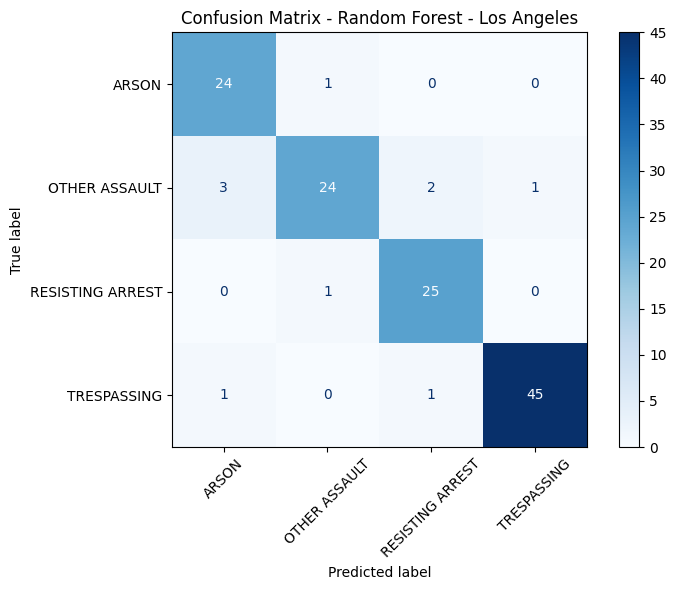


==== KNN ====
Accuracy: 0.6484375
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.84      0.58        25
           1       0.67      0.40      0.50        30
           2       0.65      0.58      0.61        26
           3       0.88      0.74      0.80        47

    accuracy                           0.65       128
   macro avg       0.66      0.64      0.63       128
weighted avg       0.70      0.65      0.65       128



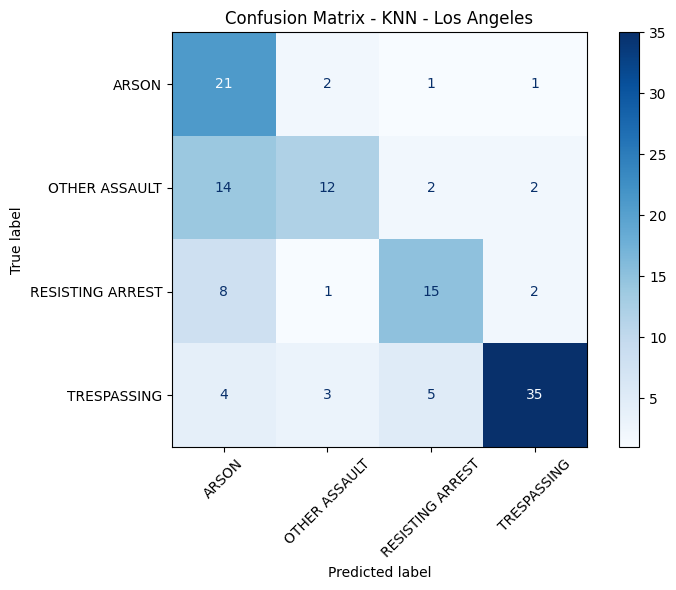


==== Naive-Bayes ====
Accuracy: 0.8203125
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.84      0.81        25
           1       0.76      0.83      0.79        30
           2       0.83      0.73      0.78        26
           3       0.89      0.85      0.87        47

    accuracy                           0.82       128
   macro avg       0.81      0.81      0.81       128
weighted avg       0.82      0.82      0.82       128



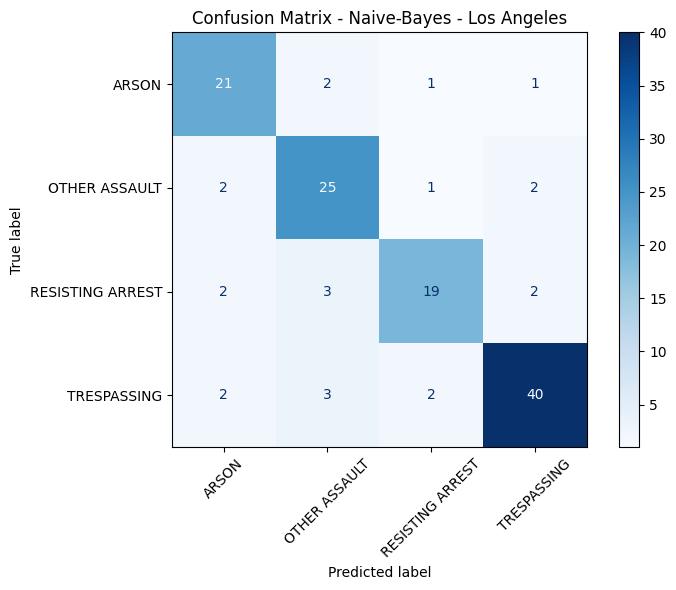


==== XGBoost ====
Accuracy: 0.9140625
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.92      0.87        25
           1       0.86      0.83      0.85        30
           2       0.96      0.92      0.94        26
           3       0.98      0.96      0.97        47

    accuracy                           0.91       128
   macro avg       0.91      0.91      0.91       128
weighted avg       0.92      0.91      0.91       128



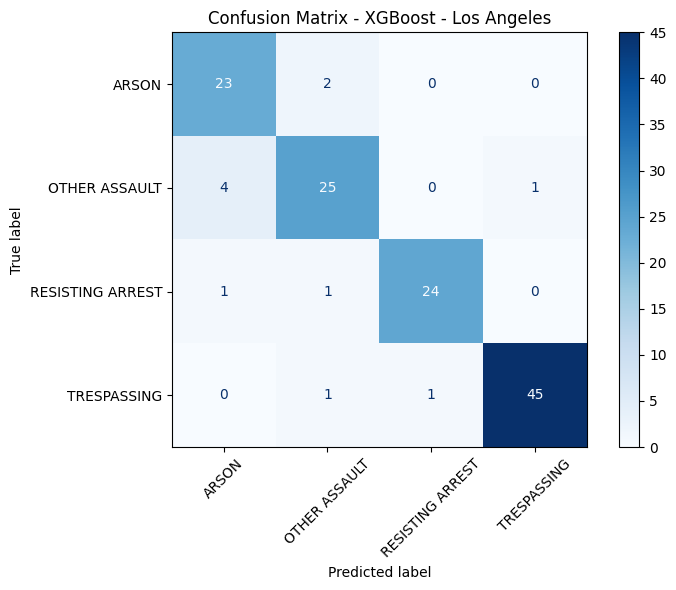


==== MLP ====
Accuracy: 0.859375
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.84      0.79        25
           1       0.89      0.80      0.84        30
           2       0.88      0.85      0.86        26
           3       0.90      0.91      0.91        47

    accuracy                           0.86       128
   macro avg       0.85      0.85      0.85       128
weighted avg       0.86      0.86      0.86       128



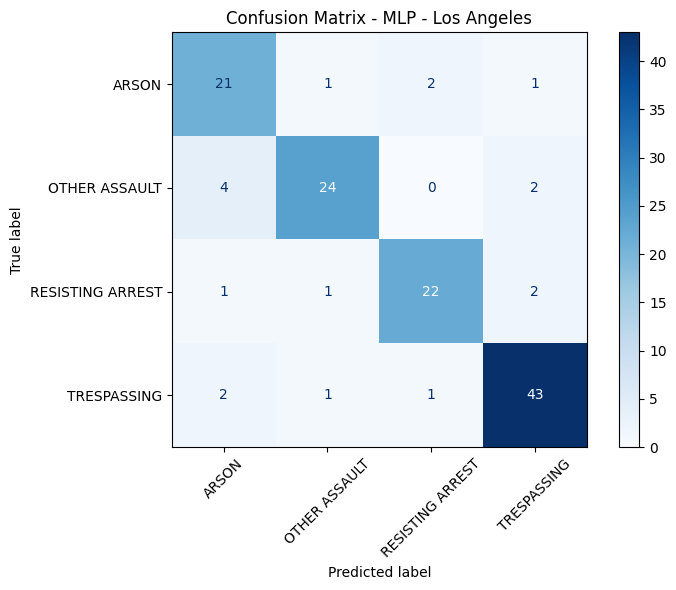

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

rf_model = joblib.load("rf_la_model.pkl")
knn_model = joblib.load("knn_la_model.pkl")
nb_model = joblib.load("naive_bayes_la_model.pkl")
xg_model = joblib.load("xgb_la_model.pkl")
mlp_model = joblib.load("mlp_la_model.pkl")


models= {
    "Random Forest": rf_model,
    "KNN": knn_model,
    "Naive-Bayes": nb_model,
    "XGBoost": xg_model,
    "MLP": mlp_model
}

print("For LA Dataset \n")
for m_name,model in models.items():
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n==== {m_name} ====")
    print("Accuracy:", acc)
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # === Confusion Matrix ===
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues", xticks_rotation=45, ax=plt.gca())
    plt.title(f"Confusion Matrix - {m_name} - Los Angeles")
    plt.tight_layout()
    plt.show()
